In [183]:
# !pip install tensorflow numpy matplotlib seaborn scikit-learn

In [184]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist

# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize the data
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Reshape the data to include channel dimension
x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

print(f'Training data shape: {x_train.shape}')
print(f'Test data shape: {x_test.shape}')

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Training data shape: (60000, 28, 28, 1)
Test data shape: (10000, 28, 28, 1)


In [185]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Define the model
model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
model.fit(x_train, y_train, epochs=5, batch_size=32, validation_split=0.2)


Epoch 1/5
  86/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6399 - loss: 1.1698

W0000 00:00:1717622903.902646      75 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9024 - loss: 0.3213 - val_accuracy: 0.9763 - val_loss: 0.0797
Epoch 2/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9826 - loss: 0.0558 - val_accuracy: 0.9840 - val_loss: 0.0588
Epoch 3/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9901 - loss: 0.0330 - val_accuracy: 0.9838 - val_loss: 0.0526
Epoch 4/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9929 - loss: 0.0218 - val_accuracy: 0.9847 - val_loss: 0.0570
Epoch 5/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9957 - loss: 0.0140 - val_accuracy: 0.9854 - val_loss: 0.0577


In [186]:
from sklearn.metrics import classification_report, confusion_matrix

# Evaluate the model
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)

# Predict the labels
y_pred = model.predict(x_test)
y_pred_classes = y_pred.argmax(axis=1)

# Print the classification report
print(f'Test accuracy: {test_acc}')
print(classification_report(y_test, y_pred_classes))

print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred_classes))

313/313 - 1s - 3ms/step - accuracy: 0.9862 - loss: 0.0471
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Test accuracy: 0.9861999750137329
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       980
           1       0.99      1.00      1.00      1135
           2       0.98      0.99      0.99      1032
           3       0.99      0.98      0.99      1010
           4       1.00      0.98      0.99       982
           5       0.99      0.98      0.98       892
           6       0.99      0.98      0.99       958
           7       0.99      0.98      0.99      1028
           8       0.96      0.99      0.98       974
           9       0.98      0.98      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000

Confusion Matrix:
[[ 976    0    0    1    0    0    1    0    2    0]
 [   0 1132    2    0    0    0    0 

## fedML

In [193]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input
from tensorflow.keras.optimizers import Adam

# Number of workers
N_WORKERS = 4
# Federated learning parameters
EPOCHS = 5
EPOCHS_WITHIN = 1

# Define the number of epochs after which to visualize weights
VISUALIZE_WEIGHT_AFTER = 1


In [194]:
# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize the data
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Reshape the data to include channel dimension
x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

# Split the data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=1/6, random_state=42)

# Split the training data among workers
x_train_splits = np.array_split(x_train, N_WORKERS)
y_train_splits = np.array_split(y_train, N_WORKERS)

# Print the shapes to verify
for i in range(N_WORKERS):
    print(f'Worker {i+1} - Training data shape: {x_train_splits[i].shape}')
print('--------------------------------------------------')
print(f'Total Training data shape: {x_train.shape}')
print(f'Validation data shape: {x_val.shape}')
print(f'Test data shape: {x_test.shape}')

Worker 1 - Training data shape: (12500, 28, 28, 1)
Worker 2 - Training data shape: (12500, 28, 28, 1)
Worker 3 - Training data shape: (12500, 28, 28, 1)
Worker 4 - Training data shape: (12500, 28, 28, 1)
--------------------------------------------------
Total Training data shape: (50000, 28, 28, 1)
Validation data shape: (10000, 28, 28, 1)
Test data shape: (10000, 28, 28, 1)


In [196]:
import warnings
warnings.filterwarnings("ignore")

# Split the training data among workers
x_train_splits = np.array_split(x_train, N_WORKERS)
y_train_splits = np.array_split(y_train, N_WORKERS)

# Define a function to create the model
def create_model():
    model = Sequential([
        Input(shape=(28, 28, 1)),
        Conv2D(32, kernel_size=(3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(10, activation='softmax')
    ])
    return model

# Initialize models for each worker
models = [create_model() for _ in range(N_WORKERS)]

# Compile models
for model in models:
    model.compile(optimizer=Adam(),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])


print(models[0].summary())

# # Define the number of epochs after which to visualize weights
# VISUALIZE_WEIGHT_AFTER = 1
# EPOCHS_WITHIN = 1
# EPOCHS = 5

# Lists to store weights for each worker
worker_weights = [[] for _ in range(N_WORKERS)]

# Initialize lists to store training and validation losses and accuracies for each worker
worker_train_losses = [[] for _ in range(N_WORKERS)]
worker_val_losses = [[] for _ in range(N_WORKERS)]
worker_train_accuracies = [[] for _ in range(N_WORKERS)]
worker_val_accuracies = [[] for _ in range(N_WORKERS)]

for epoch in range(EPOCHS):
    print(f'Epoch {epoch+1}/{EPOCHS}')
    
    # Train each worker's model for one epoch
    worker_histories = []
    for i in range(N_WORKERS):
        history = models[i].fit(x_train_splits[i], y_train_splits[i], epochs=EPOCHS_WITHIN, batch_size=32, validation_data=(x_val, y_val), verbose=1)
        worker_histories.append(history.history)
        worker_train_losses[i].append(history.history['loss'][0])
        worker_val_losses[i].append(history.history['val_loss'][0])
        worker_train_accuracies[i].append(history.history['accuracy'][0])
        worker_val_accuracies[i].append(history.history['val_accuracy'][0])
    
    # Collect and average the weights
    new_weights = [model.get_weights() for model in models]
    # Visualize weights after every VISUALIZE_WEIGHT_AFTER epochs
    if (epoch + 1) % VISUALIZE_WEIGHT_AFTER == 0:
        for i, model in enumerate(models):
            worker_weights[i].append(model.get_weights())
            
    
    # Update each worker's model with the averaged weights
    avg_weights = [np.mean([new_weights[j][k] for j in range(N_WORKERS)], axis=0) for k in range(len(new_weights[0]))]
    for model in models:
        model.set_weights(avg_weights)
    
    # Print losses and accuracies for the epoch
    epoch_train_loss = np.mean([history['loss'][0] for history in worker_histories])
    epoch_val_loss = np.mean([history['val_loss'][0] for history in worker_histories])
    epoch_train_acc = np.mean([history['accuracy'][0] for history in worker_histories])
    epoch_val_acc = np.mean([history['val_accuracy'][0] for history in worker_histories])
    print(f'Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}')
    print(f'Train Accuracy: {epoch_train_acc:.4f}, Val Accuracy: {epoch_val_acc:.4f}')
    
    

Model: "sequential_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_28 (Conv2D)              │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_28 (Flatten)            │ (None, 5408)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_56 (Dense)                │ (None, 128)            │       692,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_57 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 693,962 (2.65 MB)

 Trainable params: 693,962 (2.65 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/5
 87/391 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6767 - loss: 1.1487

W0000 00:00:1717623230.566430      77 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8237 - loss: 0.6125 - val_accuracy: 0.9489 - val_loss: 0.1798
 87/391 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6247 - loss: 1.1973

W0000 00:00:1717623234.922987      76 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8084 - loss: 0.6280 - val_accuracy: 0.9529 - val_loss: 0.1635
 86/391 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5995 - loss: 1.3043

W0000 00:00:1717623239.302126      78 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.7948 - loss: 0.6771 - val_accuracy: 0.9525 - val_loss: 0.1550
 87/391 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6594 - loss: 1.1059

W0000 00:00:1717623243.680711      77 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8159 - loss: 0.6068 - val_accuracy: 0.9499 - val_loss: 0.1663
Train Loss: 0.3551, Val Loss: 0.1662
Train Accuracy: 0.8945, Val Accuracy: 0.9510
Epoch 2/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8778 - loss: 0.4840 - val_accuracy: 0.9564 - val_loss: 0.1528
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8710 - loss: 0.5124 - val_accuracy: 0.9459 - val_loss: 0.1935
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8785 - loss: 0.4866 - val_accuracy: 0.9568 - val_loss: 0.1574
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8679 - loss: 0.4956 - val_accuracy: 0.9468 - val_loss: 0.1790
Train Loss: 0.3045, Val Loss: 0.1707
Train Accuracy: 0.9124, Val Accuracy: 0.9515
Epoch 3/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9573 - loss: 0.1480 - val_accuracy: 0.9538 - val_loss: 0.1472
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9579 - loss: 0.1434 - val_accuracy: 0.9675 - val_loss: 0.11

In [ ]:
# # Crude Visualize weights for each worker
# for worker_id, weights_history in enumerate(worker_weights):
#     for epoch, weights in enumerate(weights_history):
#         for layer_id, layer_weights in enumerate(weights):
#             plt.figure(figsize=(10, 5))
#             plt.hist(layer_weights.flatten(), bins=50)
#             plt.title(f'Worker {worker_id + 1}, Epoch {epoch + 1}, Layer {layer_id + 1}')
#             plt.xlabel('Weight Value')
#             plt.ylabel('Frequency')
#             plt.show()

In [197]:
#  Calculate the global model
final_model = create_model()
final_model.compile(optimizer=Adam(),
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])
final_model.set_weights(avg_weights)

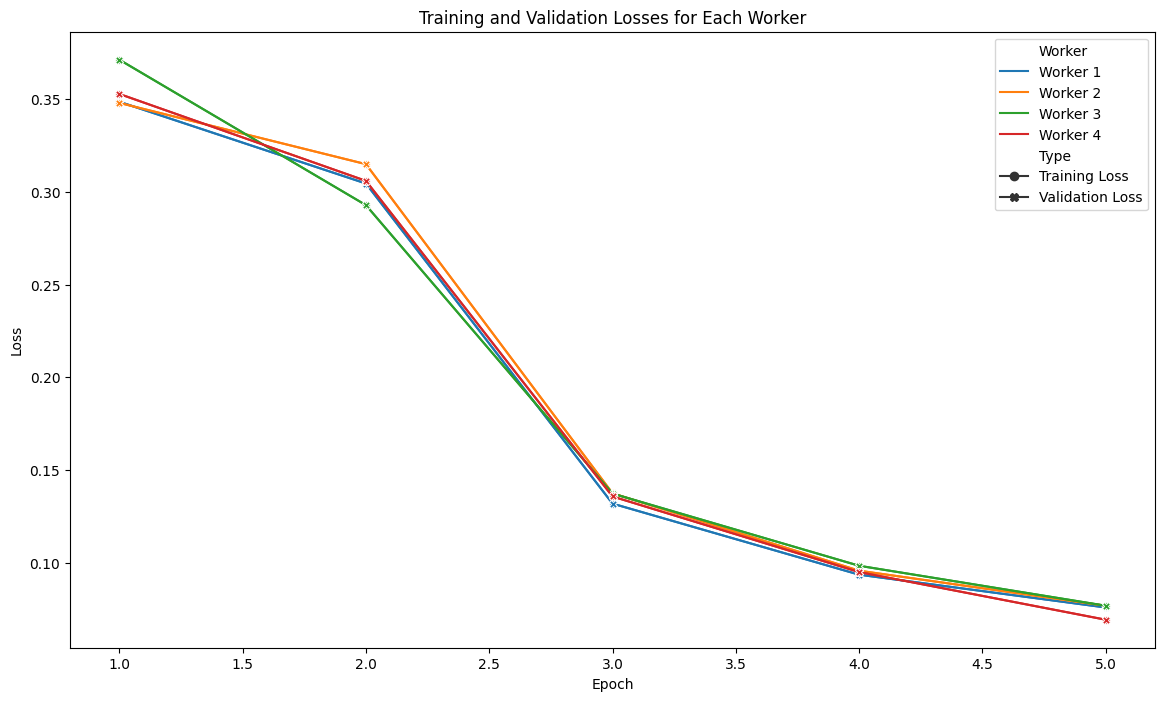

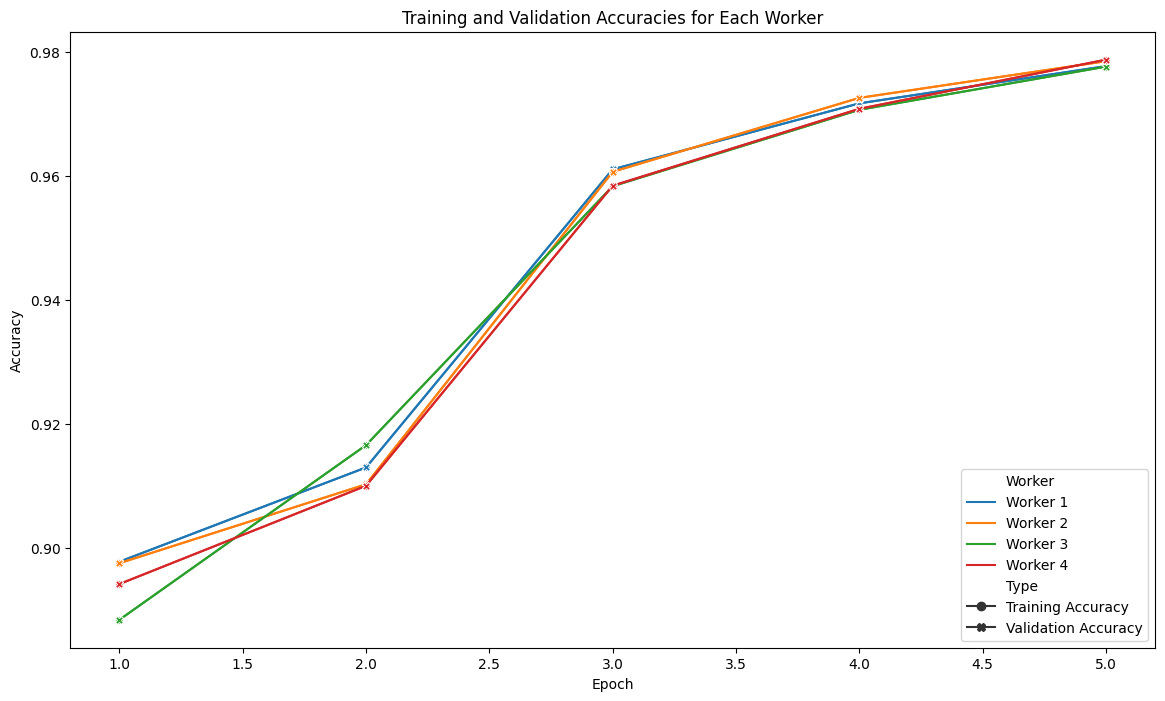

313/313 - 1s - 3ms/step - accuracy: 0.9824 - loss: 0.0544
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Test accuracy: 0.9824000000953674
Confusion Matrix:
[[ 971    0    2    0    0    0    3    1    3    0]
 [   0 1126    4    1    0    1    1    0    2    0]
 [   2    3 1014    1    3    0    0    6    2    1]
 [   0    0    1  998    0    7    0    1    2    1]
 [   0    0    0    0  974    0    0    0    2    6]
 [   2    0    0    5    0  883    2    0    0    0]
 [   7    3    0    1    3    7  935    0    2    0]
 [   1    2   11    3    0    0    0  998    2   11]
 [   3    1    5    8    1    4    0    3  943    6]
 [   4    5    1    4    5    3    0    4    1  982]]
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.98      0.98      1032
           3       0.98      0.99      0.98      1010
           4       0.99 

In [198]:
import warnings
warnings.filterwarnings("ignore")

def prepare_data_for_plotting(worker_metrics, metric_name):
    data = []
    for i in range(N_WORKERS):
        for epoch in range(EPOCHS):
            data.append([epoch + 1, worker_metrics[i][epoch], f'Worker {i+1}', f'Training {metric_name}'])
            data.append([epoch + 1, worker_metrics[i][epoch], f'Worker {i+1}', f'Validation {metric_name}'])
    return pd.DataFrame(data, columns=['Epoch', metric_name, 'Worker', 'Type'])

# Prepare data for plotting
loss_df = prepare_data_for_plotting(worker_train_losses, 'Loss')
accuracy_df = prepare_data_for_plotting(worker_train_accuracies, 'Accuracy')

# Plot losses
plt.figure(figsize=(14, 8))
sns.lineplot(data=loss_df, x='Epoch', y='Loss', hue='Worker', style='Type', markers=True, dashes=False)
plt.title('Training and Validation Losses for Each Worker')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

# Plot accuracies
plt.figure(figsize=(14, 8))
sns.lineplot(data=accuracy_df, x='Epoch', y='Accuracy', hue='Worker', style='Type', markers=True, dashes=False)
plt.title('Training and Validation Accuracies for Each Worker')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

# Evaluate the global model on the test set
test_loss, test_acc = final_model.evaluate(x_test, y_test, verbose=2)

# Predict the labels
y_pred = final_model.predict(x_test)
y_pred_classes = y_pred.argmax(axis=1)

# Print metrics
print(f'Test accuracy: {test_acc}')
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred_classes))
print('Classification Report:')
print(classification_report(y_test, y_pred_classes))

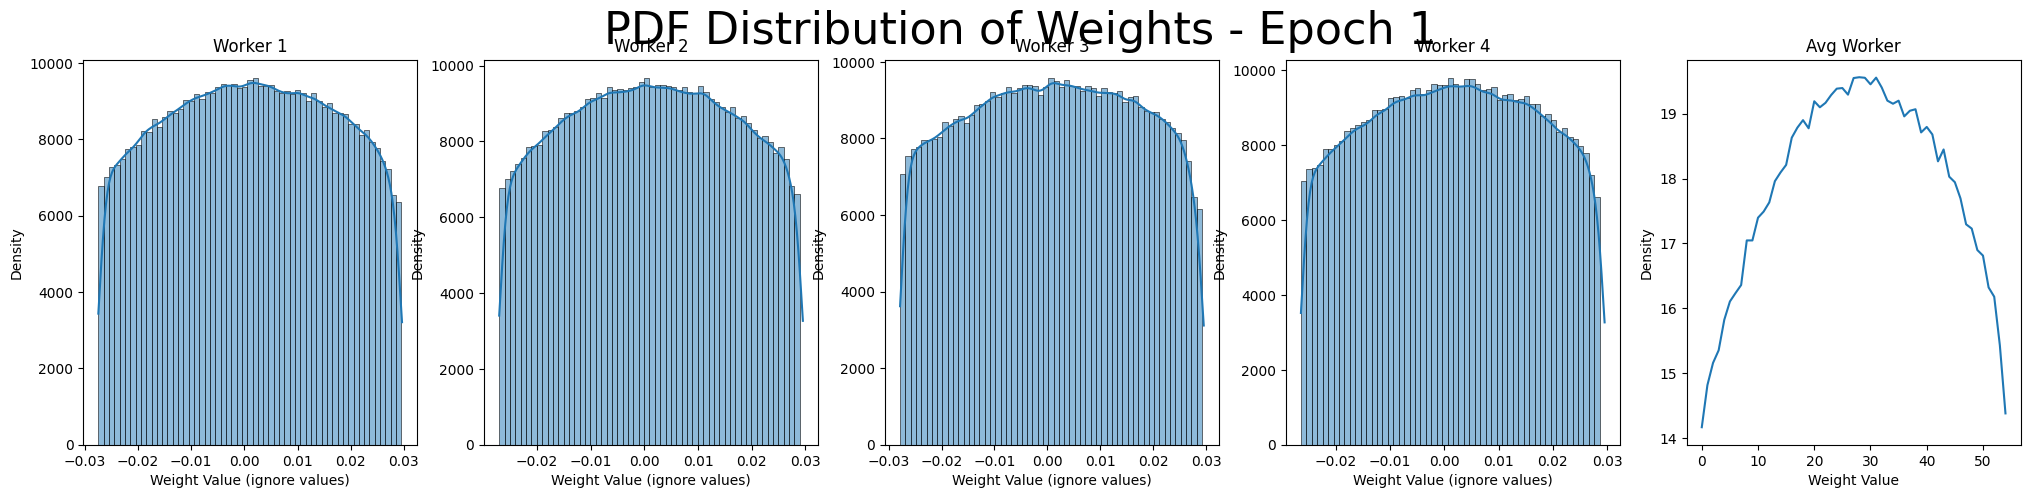

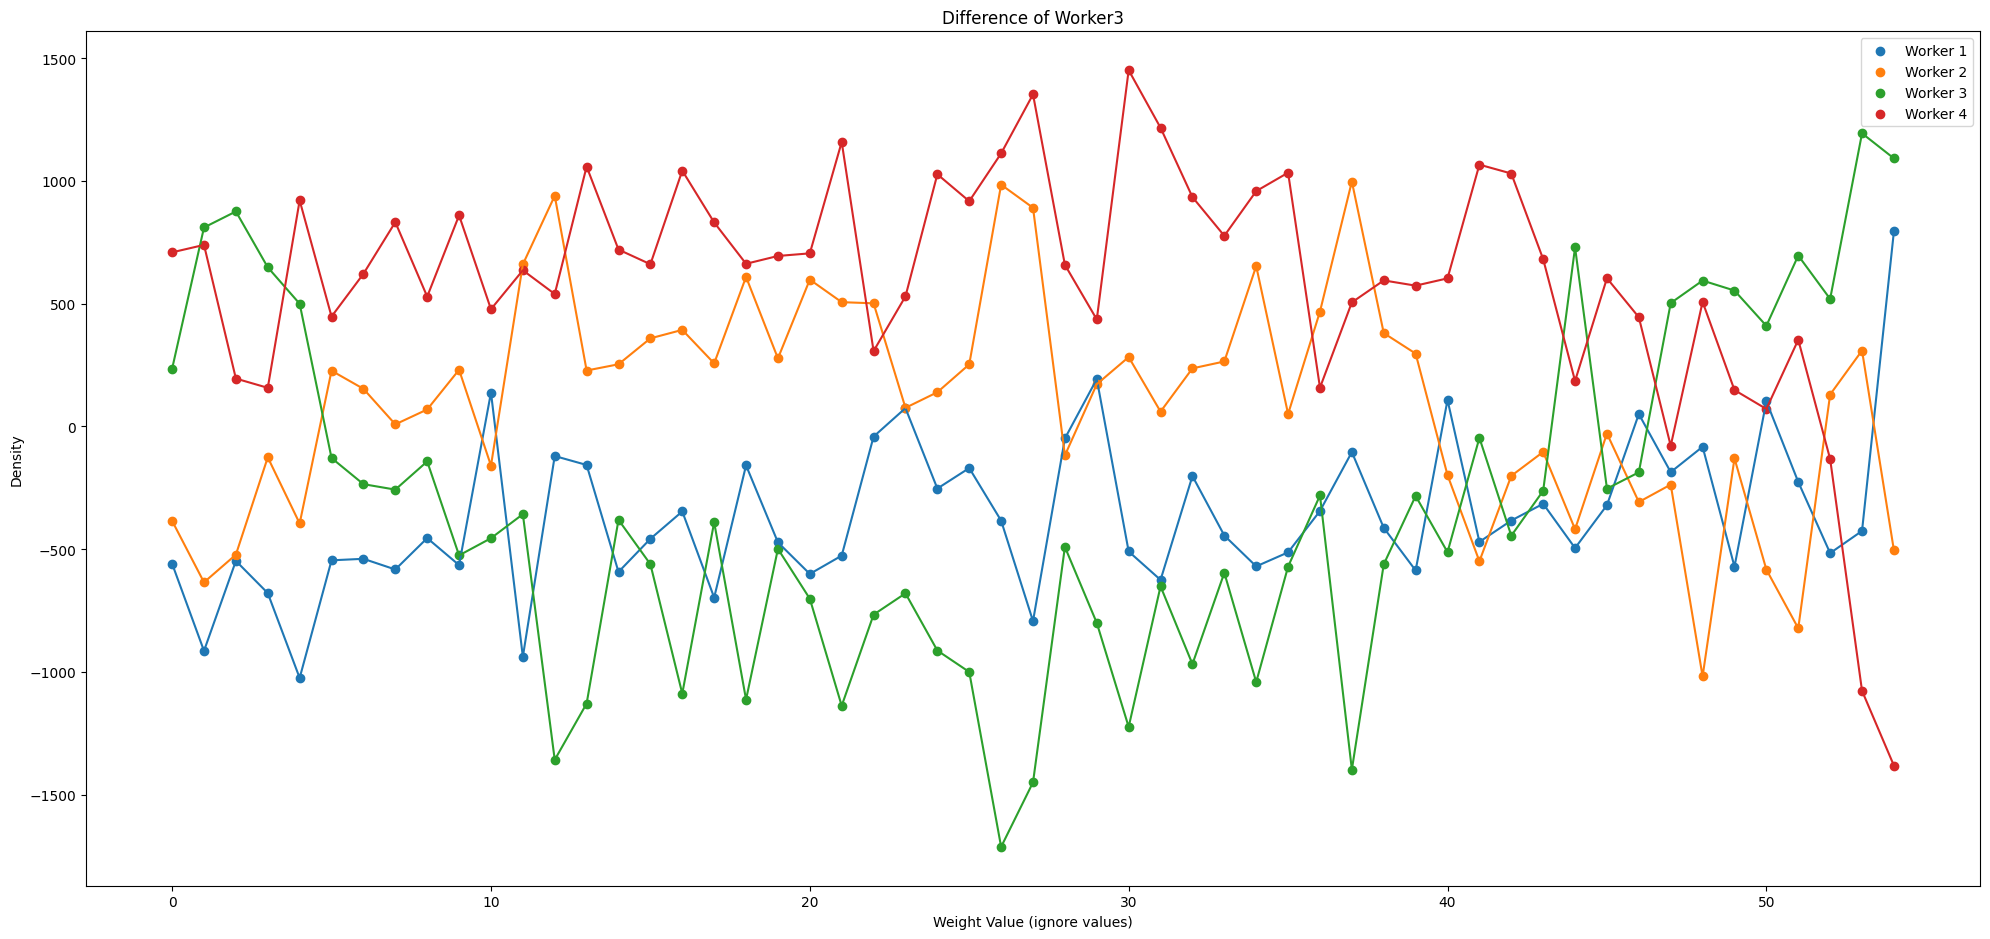

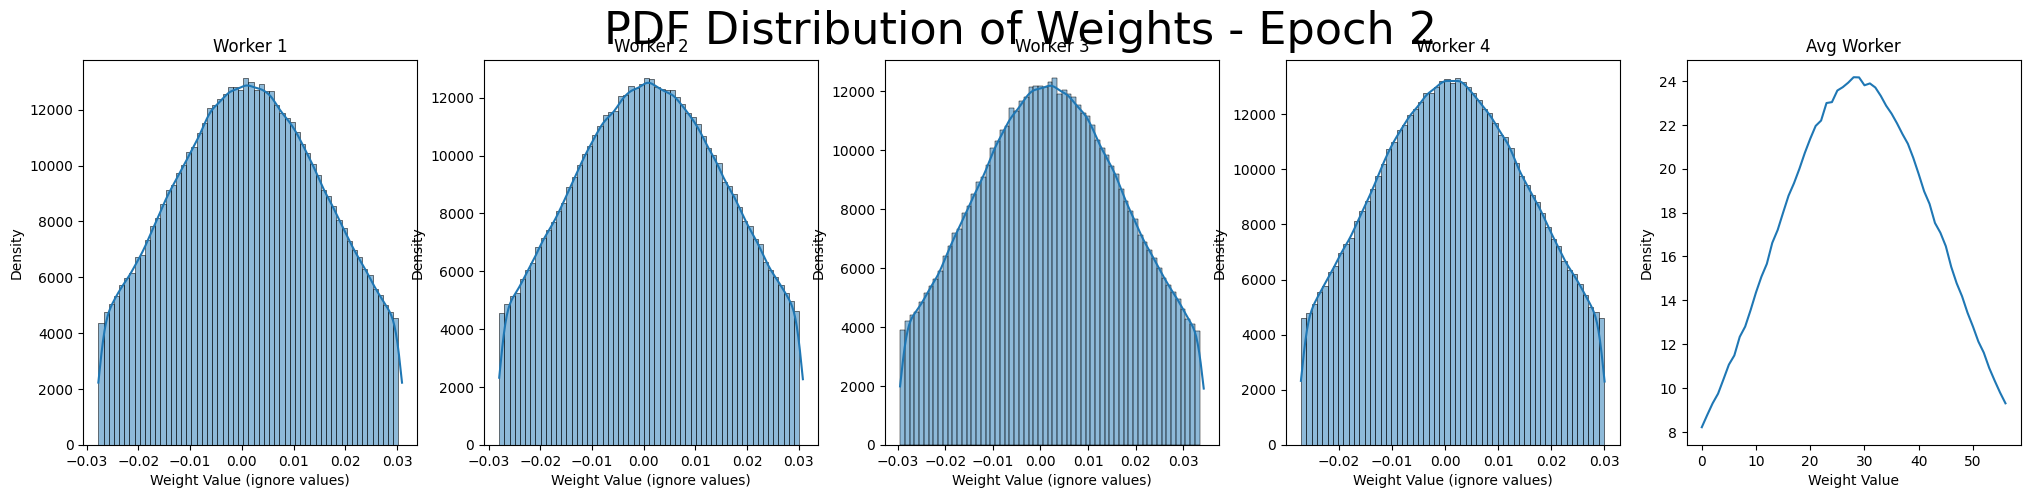

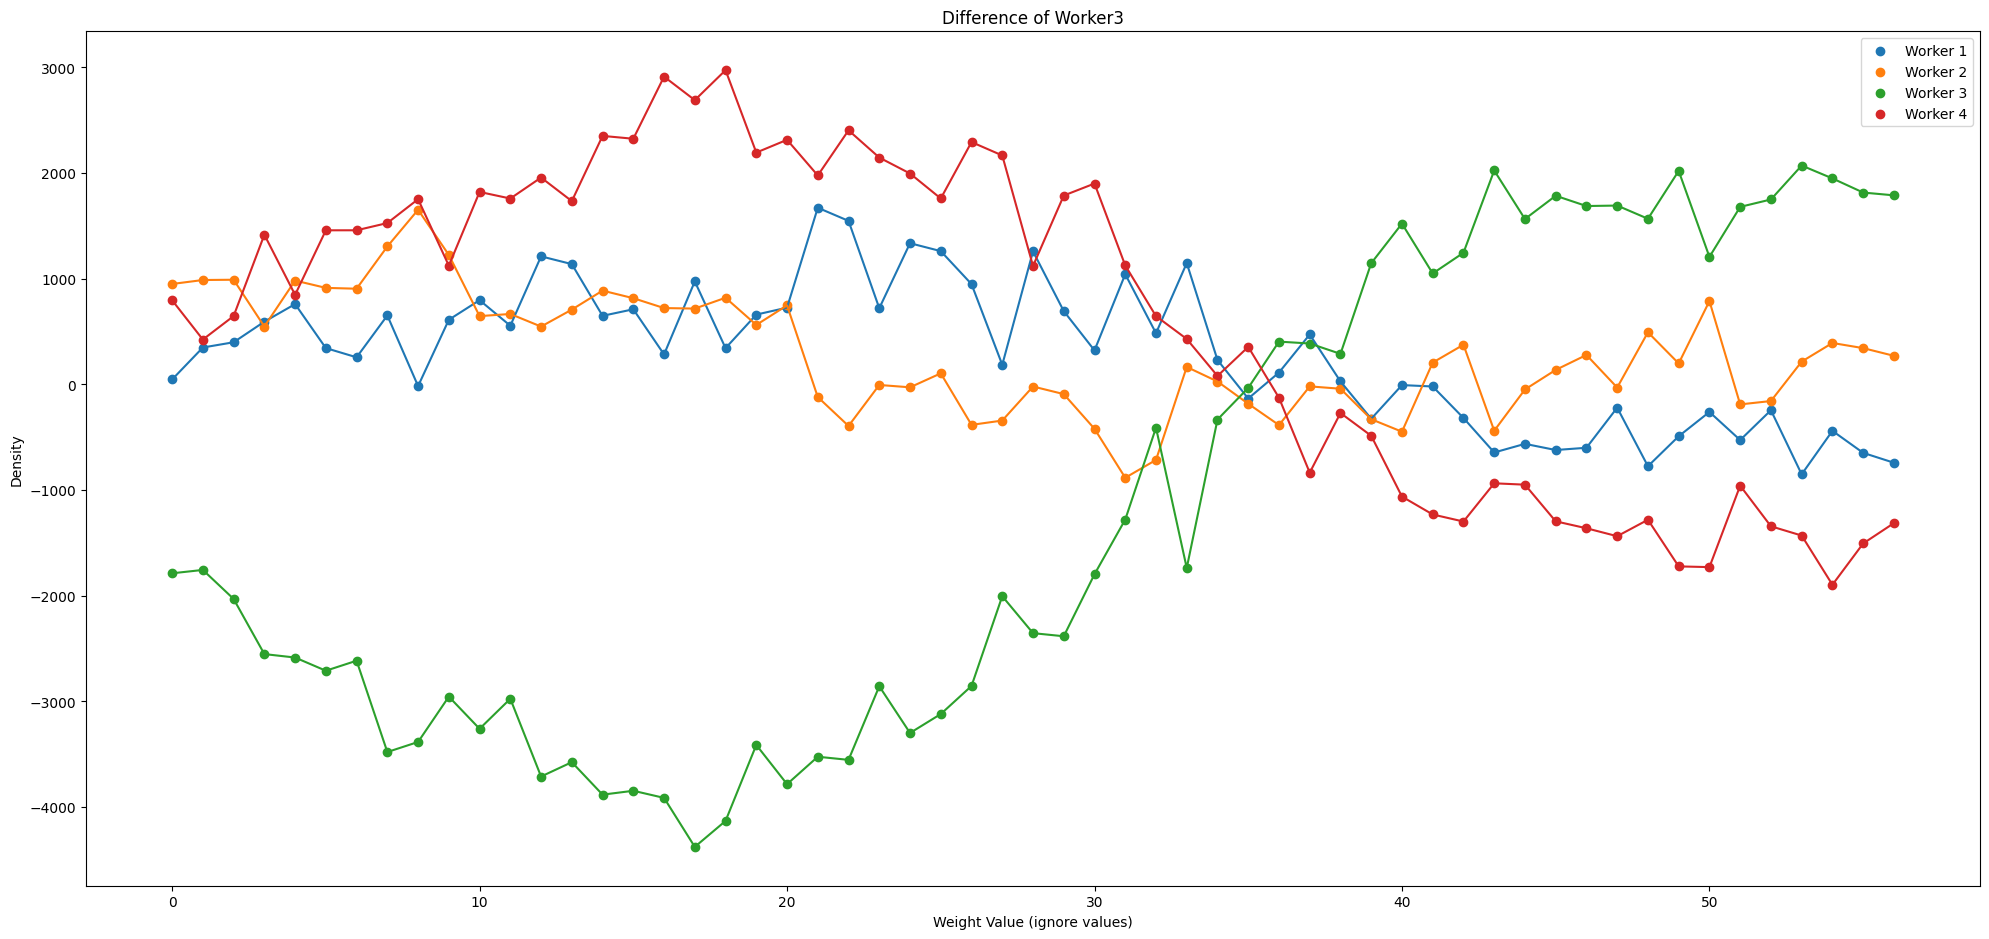

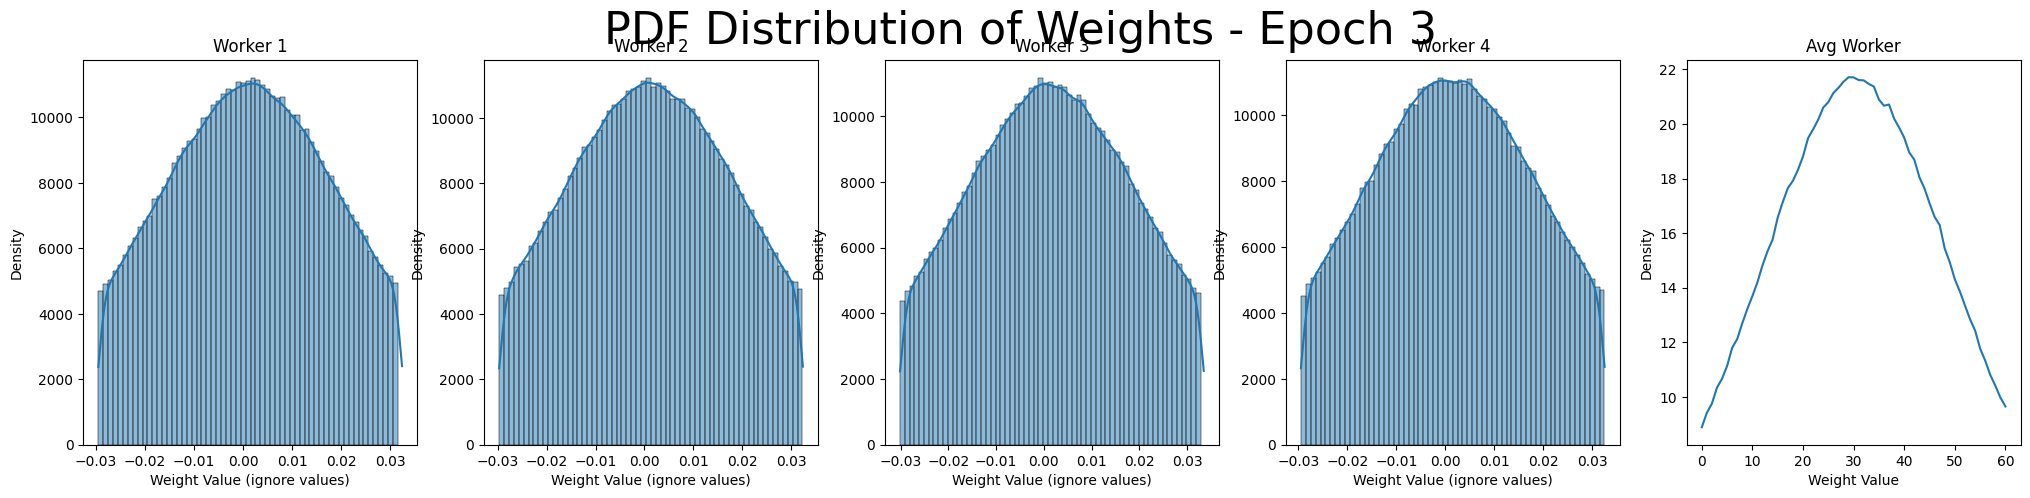

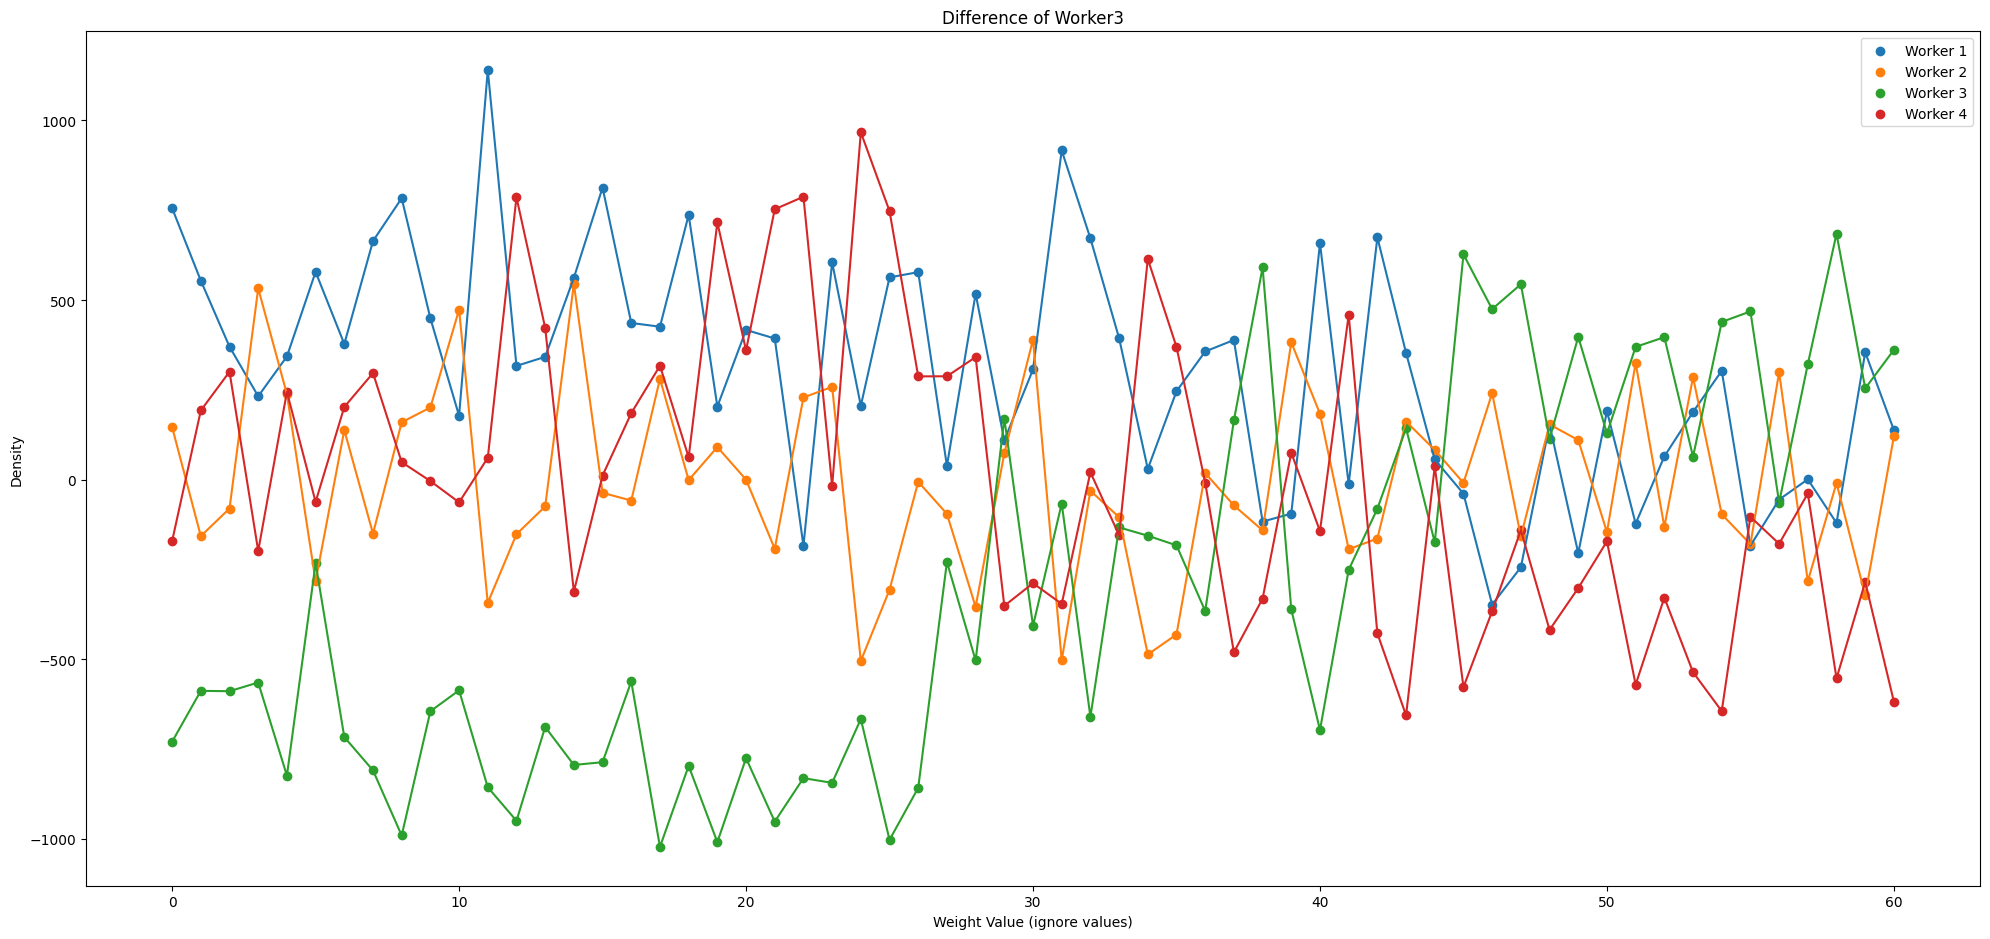

In [ ]:
def mean_axis_0(lst):
    num_rows = len(lst)
    num_cols = len(lst[0]) if lst else 0
    if num_cols == 0:
        return [] 
    min_len = min(len(row) for row in lst)
    col_means = []
    for j in range(min_len):
        col_sum = sum(lst[i][j] for i in range(num_rows))
        col_mean = col_sum / num_rows
        col_means.append(col_mean)
    return col_means , min_len


def plot_weight_distributions_across_epochs(worker_weights, epochs, n_sigma_away=1, bucket_size=0.001):
    num_workers = len(worker_weights)
    cols = (num_workers)+1  # Number of columns for subplots
    
    for epoch in range(epochs):
        fig, axes = plt.subplots(1, cols, figsize=(cols * 5, 5))  # Adjust figsize for wider graphs
        fig.suptitle(f"PDF Distribution of Weights - Epoch {epoch + 1}", fontsize=32)
        
        store_hist = []
        for worker_id, weights_history in enumerate(worker_weights):
            # Check if there are any epochs to plot
            if epoch >= len(weights_history):
                print(f"No epochs to plot for Worker {worker_id + 1}")
                continue
                
            flattened_weights = np.concatenate([w.flatten() for w in weights_history[epoch]])
            
            # Remove weights that are n_sigma_away from the mean
            mean_weight = np.mean(flattened_weights)
            std_weight = np.std(flattened_weights)
            filtered_weights = flattened_weights[np.abs(flattened_weights - mean_weight) <= n_sigma_away * std_weight]
            
            min_weight = min(filtered_weights)
            max_weight = max(filtered_weights)
                        
            bins = np.arange(min_weight, max_weight, bucket_size)
            hist, _ = np.histogram(filtered_weights, bins=bins, density=True)
            
            store_hist.append(np.array(hist))
            
            ax = axes[worker_id]
            sns.histplot(filtered_weights, bins=bins, kde=True, ax=ax)
            ax.set_title(f"Worker {worker_id + 1}")
            ax.set_xlabel("Weight Value (ignore values)")
            ax.set_ylabel("Density")
        
        avg_hist, min_len = mean_axis_0(store_hist)
        diff_hist = [hist[:min_len] - avg_hist for hist in store_hist]
#         diff_hist = [hist[:min_len] - store_hist[-1][:min_len] for hist in store_hist]

        
        plt.plot(avg_hist)
        plt.title(f"Avg Worker")
        plt.xlabel("Weight Value")
        plt.ylabel("Density")
        plt.show()
        
        for i in range(len(diff_hist)):
            diff_hist[i] = [2000*j for j in diff_hist[i]]
            
        plt.figure(figsize=(20, 10))  # Adjust the figure size as needed
        for i, sublist in enumerate(diff_hist):
            x = np.arange(len(sublist))
            y = sublist
            plt.scatter(x, y, label=f'Worker {i+1}')
            plt.title(f"Dot plot of Difference of Worker{i}")
            plt.xlabel("Weight Value (ignore values)")
            plt.ylabel("Density")
            plt.legend()
            
        
        for i in range(len(diff_hist)):
            plt.plot(diff_hist[i])
            plt.title(f"Difference of Worker{i}")
            plt.xlabel("Weight Value (ignore values)")
            plt.ylabel("Density")
            plt.legend()

        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()
        
#         break
#         return avg_hist, store_hist

# Call the function to plot weight distributions across epochs
plot_weight_distributions_across_epochs(worker_weights, EPOCHS)


In [ ]:
print(models[0].summary())

# Iterate over each epoch
for epoch in range(len(worker_weights[0])):
    # Iterate over each layer
    for layer_id in range(len(worker_weights[0][0])):
        # Initialize an empty list to store flattened weights of the current layer for all workers
        layer_weights_all_workers = []
        
        # Collect weights of the current layer for all workers at the current epoch
        for worker_id, weights_history in enumerate(worker_weights):
            # Append the flattened weights of the current layer for the current worker and epoch
            layer_weights_all_workers.append(weights_history[epoch][layer_id].flatten())
        
        # Plot the histograms of weights of the current layer for all workers in one figure
        plt.figure(figsize=(10, 5))
        plt.hist(layer_weights_all_workers, bins=50, label=[f'Worker {i+1}' for i in range(N_WORKERS)], alpha=0.7)
        plt.title(f'Epoch {epoch + 1}, Layer {layer_id + 1} - Distribution of Weights')
        plt.xlabel('Weight Value')
        plt.ylabel('Frequency')
        plt.legend()
        plt.show()

In [ ]:
def plot_weight_distribution(weights_history, worker_id, n_sigma_away=1, bucket_size=0.001):
    num_epochs = len(weights_history)
    
    # Check if there are any epochs to plot
    if num_epochs == 0:
        print(f"No epochs to plot for Worker {worker_id + 1}")
        return
    
    cols = N_WORKERS  # Number of columns for subplots
    rows = num_epochs  # Calculate the number of rows needed
    
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 5))  # Adjust figsize for wider graphs
    fig.suptitle(f"PDF Distribution of Weights for Worker {worker_id + 1}", fontsize=32)

    bin_values = []
    
    for epoch, weights in enumerate(weights_history):
        flattened_weights = np.concatenate([w.flatten() for w in weights])
        
        # Remove weights that are 3 sigma away from the mean
        mean_weight = np.mean(flattened_weights)
        std_weight = np.std(flattened_weights)
        filtered_weights = flattened_weights[np.abs(flattened_weights - mean_weight) <= n_sigma_away * std_weight]
        
        min_weight = min(filtered_weights)
        max_weight = max(filtered_weights)
        
        bins = np.arange(min_weight, max_weight, bucket_size)
        hist, _ = np.histogram(filtered_weights, bins=bins, density=True)
        
        bin_values.append(hist)

        ax = axes[epoch // cols, epoch % cols]
        sns.histplot(filtered_weights, bins=bins, kde=True, ax=ax)
        ax.set_title(f"Epoch {epoch + 1}")
        ax.set_xlabel("Weight Value")
        ax.set_ylabel("Density")

    # Remove any empty subplots
    for i in range(num_epochs, rows * cols):
        fig.delaxes(axes.flatten()[i])

    plt.tight_layout(rect=[0, 0, 1, 1])
    plt.show()
    
    return bin_values

histograms_array = [[] for i in range(EPOCHS)]
# Visualize weights for each worker
for worker_id, weights_history in enumerate(worker_weights):
    tmp2 = [i for i in plot_weight_distribution(weights_history, worker_id)] 
    for i in range(EPOCHS):
        histograms_array[i].append((tmp2[i]))

In [ ]:
# Full plot with sigma away ; Low visuality

# Define function to remove outliers and plot PDF distribution of weights
def plot_weight_distribution(weights_history, worker_id, bucket_size=0.001):
    num_epochs = len(weights_history)
    cols = N_WORKERS  # Number of columns for subplots
    rows = num_epochs  # Calculate the number of rows needed
    
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 5))  # Adjust figsize for wider graphs
    fig.suptitle(f"PDF Distribution of Weights for Worker {worker_id + 1}", fontsize=16)

    for epoch, weights in enumerate(weights_history):
        flattened_weights = np.concatenate([w.flatten() for w in weights])
        
        # Remove weights that are 3 sigma away from the mean
        mean_weight = np.mean(flattened_weights)
        std_weight = np.std(flattened_weights)
        filtered_weights = flattened_weights[np.abs(flattened_weights - mean_weight) <= 3 * std_weight]
        
        min_weight = min(filtered_weights)
        max_weight = max(filtered_weights)
        
        bins = np.arange(min_weight, max_weight, bucket_size)
        
        ax = axes[epoch // cols, epoch % cols]
        sns.histplot(filtered_weights, bins=bins, kde=True, ax=ax)
        ax.set_title(f"Epoch {epoch + 1}")
        ax.set_xlabel("Weight Value")
        ax.set_ylabel("Density")

    # Remove any empty subplots
    for i in range(num_epochs, rows * cols):
        fig.delaxes(axes.flatten()[i])

    plt.tight_layout(rect=[0, 0, 1, 1])
    plt.show()

# Visualize weights for each worker
for worker_id, weights_history in enumerate(worker_weights):
    plot_weight_distribution(weights_history, worker_id)
#     break  # Remove this line if you want to visualize for all workers
